## Zip folder



In [ ]:
import shutil
from google.colab import files

# Specify the directory you want to compress
directory_to_zip = '/content/bertopic_models2/model_k=15'  # Replace with your directory name

# Create a zip file
shutil.make_archive(directory_to_zip, 'zip', directory_to_zip)

# Download the zipped file
files.download(f'{directory_to_zip}.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Unzip file

In [ ]:
import zipfile
import os

# Define the path of the uploaded zip file
zip_file_path = "/content/model_k=16.zip"  # Gets the name of the uploaded file dynamically

# Create a directory to extract the files
extraction_path = '/content/bertopic_models'
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Check the extracted files
print("Extracted files:", os.listdir(extraction_path))

Extracted files: ['model_k=16']


In [ ]:
!pip install hazm

In [ ]:
%%time
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
CPU times: user 46.2 ms, sys: 12.2 ms, total: 58.4 ms
Wall time: 4.93 s


In [ ]:
%%time
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import re
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import json
import time
# from hazm import Stemmer

CPU times: user 28.9 s, sys: 1.71 s, total: 30.6 s
Wall time: 1min 5s


In [ ]:
def save_dict(data, file_name):
  path = f"/content/metrics/{file_name}"
  print("path:", path)
  with open(path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

In [ ]:
def save_model(model, embedding_model, filename):
  model.save(f"/content/bertopic_models2/{filename}", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

names of folders to create before run the code:

bertopic_models

metrics

purity_dfs

1) preprocess the data

In [ ]:
import re
import pandas as pd
from hazm import Stemmer

In [ ]:
def clean_docs(df, tweet_column_name):

  stemmer = Stemmer()
  foo_dict = {}

  with open('/content/stop_words.txt', 'r') as f:
    stop_words = [word.strip() for word in f.read().splitlines()]

  def remove_stopwords(words):
      return [word for word in words if word not in stop_words]

  def preprocess(text):
      # Remove URLs
      text = re.sub(r'http\S+', '', text)

      # Remove emojis
      emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"❤️"
                            "]+", flags=re.UNICODE)
      text = emoji_pattern.sub(r'', text)

      # Remove emoji-like codes (_xD83D__xDD34_ pattern)
      emoji_code_pattern = r'_x[0-9A-Fa-f]{4}__x[0-9A-Fa-f]{4}_'
      text = re.sub(emoji_code_pattern, '', text)

      # Remove english letters
      text = re.sub(r'\b[a-zA-Z0-9_]+\b', '', text)

      # Remove numbers
      text = re.sub(r'[\d۰-۹]+', '', text)

      # Remove hashtags
      text = re.sub(r'#\S+', '', text)

      # Remove mentions (with @)
      text = re.sub(r'@\S+', '', text)

      # Replace '/' with space
      text = text.replace('/', '')

      # Remove semi space
      text = text.replace('\u200C', '')


      # Remove punctuations؟
      text = re.sub(r'[%٪=-؟.,،!?؛:«»()]', '', text)

      # Tokenize text into words
      words = text.split()

      # Remove stopwords
      words = remove_stopwords(words)

      for word in words:
        foo_dict[word] = stemmer.stem(word)

      # Stem
      words = [stemmer.stem(word) for word in words]

      # Remove short tweets
      if len(words) >= 6:
        words = ' '.join(words)

        return words

  df = df.dropna(subset=[tweet_column_name])
  df = df.drop_duplicates(subset=[tweet_column_name], keep='last')

  df['cleaned_tweets'] = df[tweet_column_name].apply(preprocess)
  df = df.dropna(subset=['cleaned_tweets'])
  df = df.reset_index(drop=True)

  print("docs cleaned")

  return df, foo_dict

In [ ]:
df = pd.read_excel('cleaned_labeled_dataset.xlsx')
labeled_tweet_column_name = 'main_tweet'
df, foo = clean_docs(df, labeled_tweet_column_name)
foo

docs cleaned


{'محسن': 'محسن',
 'زنگنه': 'زنگنه',
 'نایب': 'نایب',
 'رئیس': 'رئیس',
 'کمیسیون': 'کمیسیون',
 'برنامه': 'برنامه',
 'بودجه': 'بودجه',
 'مجلس': 'مجلس',
 'همان': 'ه',
 'میگوید': 'میگوید',
 'سه': 'سه',
 'ماه': 'ماه',
 'جدال': 'جدال',
 'گوییم': 'گو',
 'دلایل': 'دلایل',
 'تورم': 'تور',
 'فروش': 'فرو',
 'محصولات': 'محصول',
 'شرکتهای': 'شرکت',
 'بزرگ': 'بزرگ',
 'دلار': 'دلار',
 'تلگرامی': 'تلگرام',
 'دولت': 'دول',
 'زورش': 'زور',
 'اینها': 'این',
 'رسد': 'رسد',
 'سهامشان': 'سهام',
 'متعلق': 'متعلق',
 'بانکها': 'بانک',
 'صندوقهای': 'صندوق',
 'بازنشستگی': 'بازنشستگ',
 'ستاد': 'ستاد',
 'اجرایی': 'اجرا',
 'لعنت': 'لعن',
 'بهتون': 'بهتون',
 'چهارتا': 'چهارتا',
 'میوه': 'میوه',
 'نمیشه': 'نمیشه',
 'خرید': 'خرید',
 'مهار': 'مهار',
 'تورمتون': 'تورمتون',
 'هزینه': 'هزینه',
 'فایده': 'فایده',
 'زندگی': 'زندگ',
 'تهران': 'تهر',
 'مشاغل': 'مشاغل',
 'درامد': 'درامد',
 'صرفه': 'صرفه',
 'سبب': 'سبب',
 'گسترش': 'گستر',
 'حاشیه': 'حاشیه',
 'نشینی': 'نشین',
 'گرانی': 'گران',
 'کاذب': 'کاذب',
 'ویدیویی': 'ویدیو

In [ ]:
import json

with open("stemmed.json", "w") as f:
    json.dump(foo, f)

In [ ]:
labeled_df = pd.read_excel('dataset overview (9).xlsx', sheet_name="100_labels")
labeled_tweet_column_name = 'main_tweet'
labeled_df = clean_docs(labeled_df, labeled_tweet_column_name)
labeled_tweet_column_name = 'cleaned_tweets'
print(f"len labeled_df: {len(labeled_df)}")

docs cleaned
len labeled_df: 660


In [ ]:
%%time
df = pd.read_csv('/content/FinalDataWithSwearDetectedAndStanceAndCleaned1402_10_24.csv')
tweet_column_name = 'main_tweet'
df = clean_docs(df, tweet_column_name)
docs = df['cleaned_tweets'].tolist()
print(f"len df: {len(df)}")

docs cleaned
len df: 297854
CPU times: user 50.1 s, sys: 444 ms, total: 50.5 s
Wall time: 50.5 s


In [ ]:
%%time
labeled_df = pd.read_excel("cleaned_labeled_dataset.xlsx")
labeled_tweet_column_name = 'cleaned_tweets'

CPU times: user 330 ms, sys: 22.6 ms, total: 353 ms
Wall time: 487 ms


2) Prepare BERTopic

In [ ]:
%%time
embedding_model = SentenceTransformer("myrkur/sentence-transformer-parsbert-fa")

modules.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/651M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

CPU times: user 1.31 s, sys: 1.09 s, total: 2.4 s
Wall time: 13.5 s


In [ ]:
k_values = [i for i in range(2, 20)]
purity_per_k = {}
precision_per_k = {}
recall_per_k = {}
f1_per_k = {}

In [ ]:
df = pd.read_excel("cleaned_dataset.xlsx")

For each k from 2 to 19, BERTopic was run with K-Means clustering, each labeled tweet was assigned to the closest cluster, and the cluster label was determined based on the majority class. Then, a logistic regression classifier was trained on the labeled data and evaluated using precision, recall, and F1-score.

In [ ]:
%%time
start_time = time.time()
docs = df['cleaned_tweets'].tolist()

for k in k_values:
  # clustering
  print("\n----k:", k, "----")
  modeling_start_time = time.time()

  # cluster_model = KMeans(n_clusters=k)
  # topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model, calculate_probabilities=True)
  # print("----BERTopic created in :", time.time() - modeling_start_time)

  # topics, probs = topic_model.fit_transform(docs)
  # print("----topic model trained in :", time.time() - modeling_start_time)

  # save_model(topic_model, embedding_model, f"model_k={k}")
  # print("----model saved in :", time.time() - modeling_start_time)
  topic_model = BERTopic.load(f"/content/bertopic_models/model_k={k}")

  info_df = topic_model.get_topic_info()

  print("----getting document_info...")
  document_info = topic_model.get_document_info(docs)
  topic_centroids = topic_model.topic_embeddings_

  # label clusters and calculate purity
  print("----labeling clusters and purity calculation started...")
  purity_df, average_purity, overall_purity = label_cluster_and_calculate_purity(k, info_df, labeled_df, labeled_tweet_column_name)
  purity_per_k[k] = (average_purity, overall_purity)

  # classify
  print("----labeling all data started...")
  labelling_start_time = time.time()
  document_info = label_all(purity_df, document_info)
  print("----data labeled in :", time.time() - labelling_start_time)

  X_train, y_train, X_test, y_test = vectorize(document_info, labeled_df)
  print("----data vectorized in :", time.time() - labelling_start_time)

  print("----LR classification started:")
  classification_start_time = time.time()
  precision, recall, f1, _ = classify(X_train, y_train, X_test, y_test)
  print("----data classified in :", time.time() - classification_start_time)

  precision_per_k[k] = precision
  recall_per_k[k] = recall
  f1_per_k[k] = f1

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
# Save execution time to a file
with open('execution_time.txt', 'w') as file:
    file.write(f"Execution Time: {execution_time} seconds")

2024-10-10 12:08:34,896 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.



----k: 12 ----
----getting document_info...
----labeling clusters and purity calculation started...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Cluster 0:
  Cluster Name: ایر_بچه_خیل_دوس
  Majority Class: فرزندآوری
  Purity: 0.55 (28 out of 51 points)
Cluster 1:
  Cluster Name: ایر_قیم_دلار_تور
  Majority Class: بورس
  Purity: 0.37 (83 out of 223 points)
Cluster 2:
  Cluster Name: شهید_خان_رضا_آقا
  Majority Class: مبارزه با حکومت جمهوری اسلامی ایران
  Purity: 0.42 (11 out of 26 points)
Cluster 3:
  Cluster Name: اسلام_جمهور_انقلاب_رهبر
  Majority Class: مبارزه با حکومت جمهوری اسلامی ایران
  Purity: 0.71 (37 out of 52 points)
Cluster 4:
  Cluster Name: ایر_اسرائیل_کشور_آمریکا
  Majority Class: فلسطین
  Purity: 0.75 (77 out of 102 points)
Cluster 5:
  Cluster Name: حجاب_قانون_زن_جامعه
  Majority Class: حجاب
  Purity: 0.59 (29 out of 49 points)
Cluster 6:
  Cluster Name: دخ_مهسا_خیل_زن
  Majority Class: حجاب
  Purity: 0.36 (9 out of 25 points)
Cluster 7:
  Cluster Name: اما_حجاب_خدا_عل
  Majority Class: حجاب
  Purity: 0.56 (9 out of 16 points)
Cluster 8:
  Cluster Name: ایر_اقتصاد_کشور_جمهور
  Majority Class: مبارزه با حکومت جمه

2024-10-10 12:08:52,643 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.



Overall Precision: 0.4760

Overall Recall: 0.4500

Overall F1 Score: 0.4605
----data classified in : 10.302984476089478

----k: 13 ----
----getting document_info...
----labeling clusters and purity calculation started...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Cluster 0:
  Cluster Name: بچه_ایر_زن_خیل
  Majority Class: فرزندآوری
  Purity: 0.60 (26 out of 43 points)
Cluster 1:
  Cluster Name: شهید_خان_رضا_آقا
  Majority Class: مبارزه با حکومت جمهوری اسلامی ایران
  Purity: 0.45 (10 out of 22 points)
Cluster 2:
  Cluster Name: حجاب_قانون_جامعه_زن
  Majority Class: حجاب
  Purity: 0.57 (29 out of 51 points)
Cluster 3:
  Cluster Name: اقتصاد_ایر_دلار_قیم
  Majority Class: بورس
  Purity: 0.50 (76 out of 153 points)
Cluster 4:
  Cluster Name: ایر_اسرائیل_کشور_جنگ
  Majority Class: فلسطین
  Purity: 0.76 (79 out of 104 points)
Cluster 5:
  Cluster Name: اسلام_جمهور_انقلاب_رهبر
  Majority Class: مبارزه با حکومت جمهوری اسلامی ایران
  Purity: 0.70 (33 out of 47 points)
Cluster 6:
  Cluster Name: اما_حجاب_خدا_عل
  Majority Class: حجاب
  Purity: 0.56 (9 out of 16 points)
Cluster 7:
  Cluster Name: دخ_مهسا_خیل_خان
  Majority Class: حجاب
  Purity: 0.47 (8 out of 17 points)
Cluster 8:
  Cluster Name: ایر_اقتصاد_کشور_جمهور
  Majority Class: مبارزه با حکومت جمه

Plot the effect of K on the average purity of clusters during the clustering phase, as well as the precision, recall, and F1-score during the classification phase

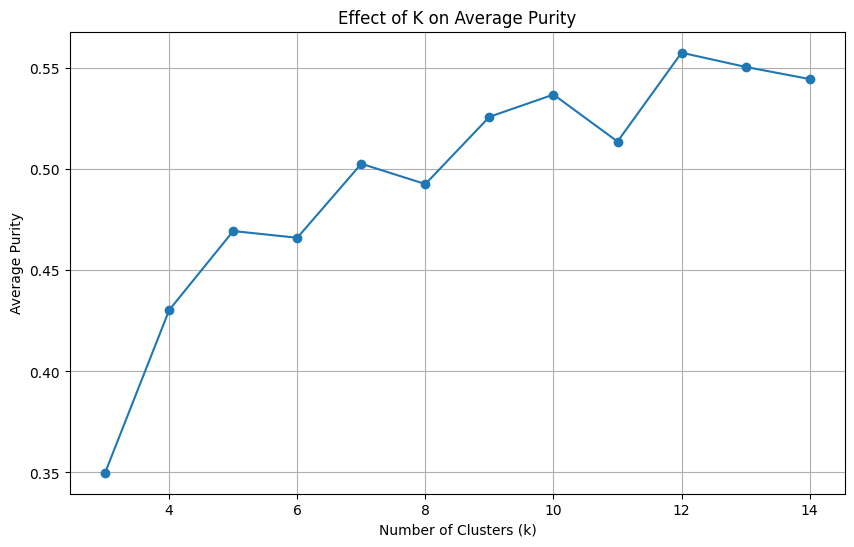

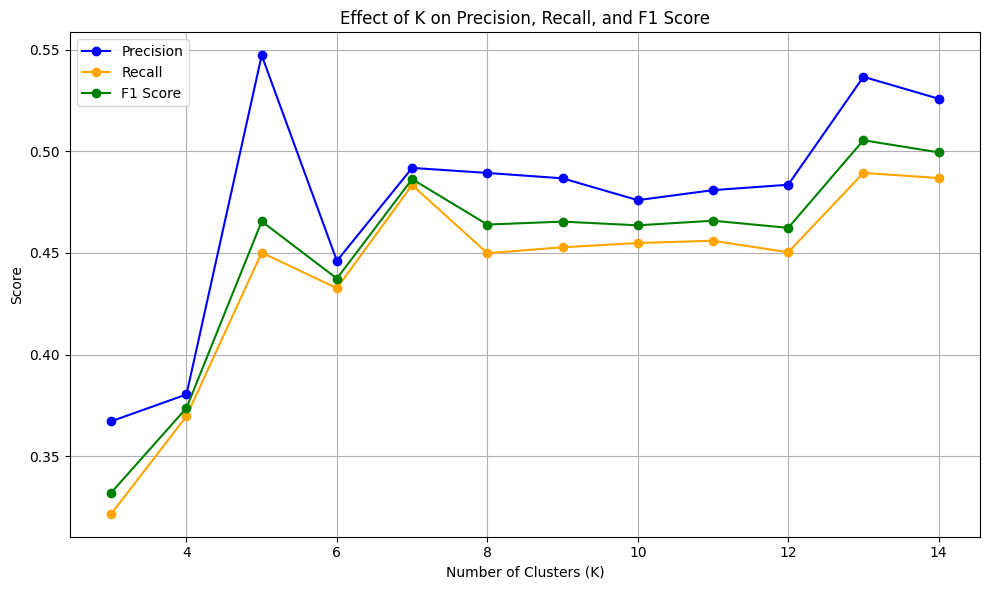

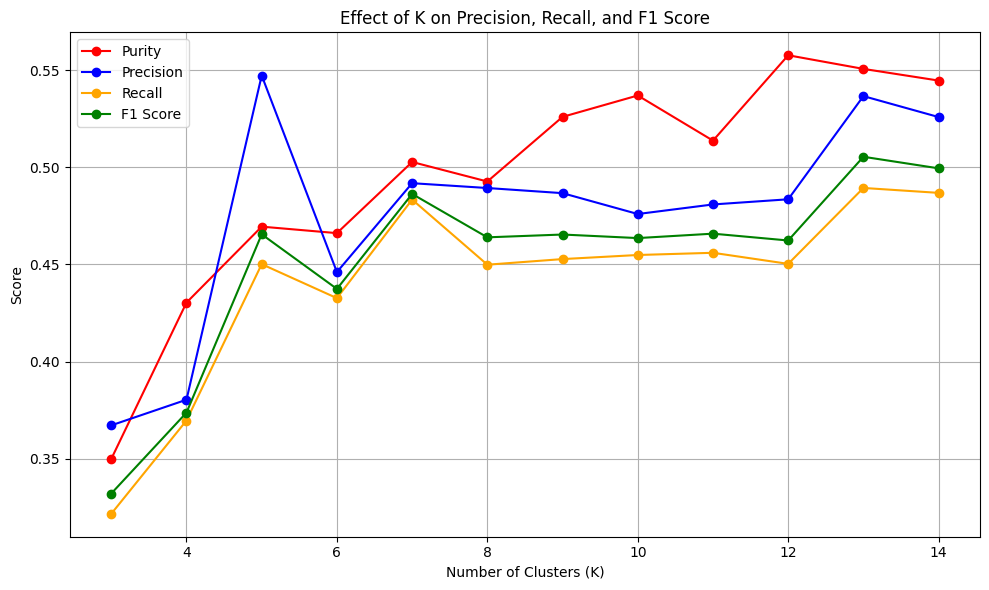

path: /content/metrics/purity_per_k_14.json
path: /content/metrics/precision_per_k_14.json
path: /content/metrics/recall_per_k_14.json
path: /content/metrics/f1_per_k_14.json


In [ ]:
# plot
draw_k_vs_purity_plot(purity_per_k)
draw_k_vs_precion_recall_f1_plot(precision_per_k, recall_per_k, f1_per_k)
draw_k_vs_purity_precion_recall_f1_plot(purity_per_k, precision_per_k, recall_per_k, f1_per_k)

# save to file
save_dict(purity_per_k, f'purity_per_k_{k_values[-1]}.json')
save_dict(precision_per_k, f'precision_per_k_{k_values[-1]}.json')
save_dict(recall_per_k, f'recall_per_k_{k_values[-1]}.json')
save_dict(f1_per_k, f'f1_per_k_{k_values[-1]}.json')

Plot the effect of K during the clustering phase on precision, recall, and F1-score in the classification phase

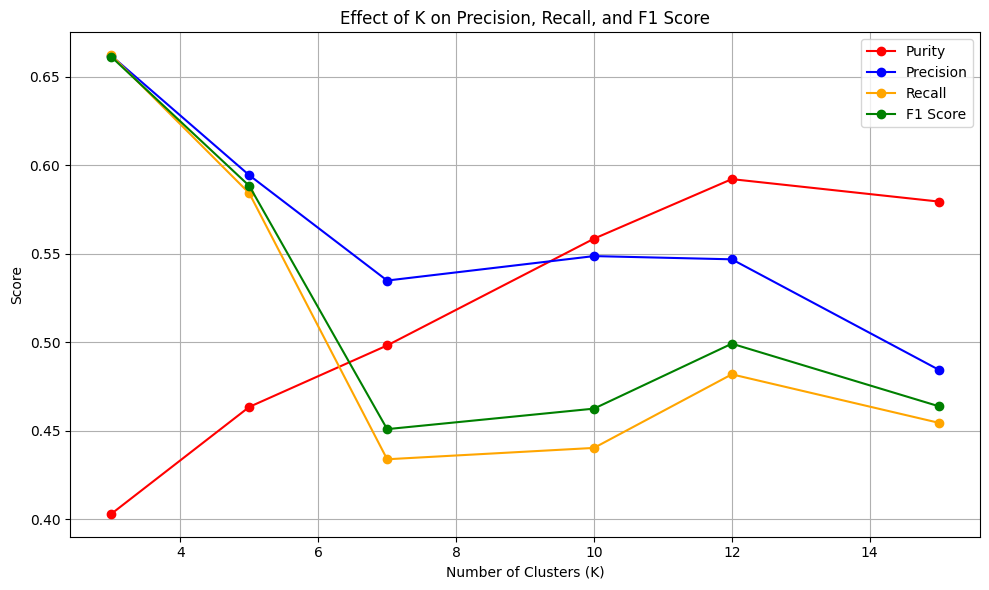

In [ ]:
draw_k_vs_precion_recall_f1_plot(precision_per_k, recall_per_k, f1_per_k)

In [ ]:
def draw_k_vs_purity_plot(purity_per_k):
  # Step 10: Plot the results
  plt.figure(figsize=(10, 6))
  plt.plot(list(purity_per_k.keys()), [value[0] for value in purity_per_k.values()], marker='o')
  plt.title("Effect of K on Average Purity")
  plt.xlabel("Number of Clusters (k)")
  plt.ylabel("Average Purity")
  plt.grid(True)
  plt.show()

In [ ]:
def draw_k_vs_precion_recall_f1_plot(precision_per_k, recall_per_k, f1_per_k):
  # Step 10: Plot the results
    plt.figure(figsize=(10, 6))

    # Plot Precision
    plt.plot(list(precision_per_k.keys()), list(precision_per_k.values()), marker='o', color='blue', label='Precision')

    # Plot Recall
    plt.plot(list(recall_per_k.keys()), list(recall_per_k.values()), marker='o', color='orange', label='Recall')

    # Plot F1 Score
    plt.plot(list(f1_per_k.keys()), list(f1_per_k.values()), marker='o', color='green', label='F1 Score')

    # Adding titles and labels
    plt.title("Effect of K on Precision, Recall, and F1 Score")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Score")

    # Adding a grid
    plt.grid(True)

    # Adding a legend
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def draw_k_vs_purity_precion_recall_f1_plot(purity_per_k, precision_per_k, recall_per_k, f1_per_k):
  # Step 10: Plot the results
    plt.figure(figsize=(10, 6))

    # Plot Purity
    plt.plot(list(purity_per_k.keys()), [value[0] for value in purity_per_k.values()], marker='o', color='red', label='Purity')

    # Plot Precision
    plt.plot(list(precision_per_k.keys()), list(precision_per_k.values()), marker='o', color='blue', label='Precision')

    # Plot Recall
    plt.plot(list(recall_per_k.keys()), list(recall_per_k.values()), marker='o', color='orange', label='Recall')

    # Plot F1 Score
    plt.plot(list(f1_per_k.keys()), list(f1_per_k.values()), marker='o', color='green', label='F1 Score')

    # Adding titles and labels
    plt.title("Effect of K on Precision, Recall, and F1 Score")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Score")

    # Adding a grid
    plt.grid(True)

    # Adding a legend
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

3) Label clusters and calculate purity
For each cluster, assign a label based on the majority label of the labeled tweets within the cluster.

In [ ]:
def label_cluster_and_calculate_purity(k, info_df, labeled_df, tweet_column_name):
  # Step 1:
  labeled_docs = labeled_df[tweet_column_name]
  labels = labeled_df['label']

  # Compute document embeddings for the labeled data (assuming `embedding_model` is defined)
  document_embeddings = embedding_model.encode(labeled_docs, show_progress_bar=True)

  # Get the topic centroids from the BERTopic model (after fitting)
  topic_centroids = topic_model.topic_embeddings_

  # Step 2: Calculate the Euclidean distance of each document to each topic centroid
  distances = pairwise_distances(document_embeddings, topic_centroids, metric='euclidean')

  # Step 3: Find the nearest cluster for each document
  nearest_cluster_indices = np.argmin(distances, axis=1)  # Index of the nearest topic centroid for each document

  # Step 4: Create a DataFrame with documents, their true labels, and their assigned clusters
  data_df = pd.DataFrame({
      'Document': labeled_docs,
      'True_Label': labels,
      'Assigned_Cluster': nearest_cluster_indices
  })

  # Step 5: Calculate the purity for each cluster
  cluster_purities = []
  cluster_labels = []

  for cluster_id in sorted(data_df['Assigned_Cluster'].unique()):
      # Get the subset of data points that are assigned to the current cluster
      cluster_data = data_df[data_df['Assigned_Cluster'] == cluster_id]

      # Get the most common label in the cluster
      majority_class = cluster_data['True_Label'].mode()[0]  # The label that appears most frequently

      # Calculate purity as the count of the majority class divided by the total number of data points in the cluster
      majority_class_count = sum(cluster_data['True_Label'] == majority_class)
      cluster_size = len(cluster_data)
      purity = majority_class_count / cluster_size

      # Store the cluster purity and majority class label
      cluster_purities.append(purity)
      cluster_labels.append(majority_class)

      print(f"Cluster {cluster_id}:")
      print(f"  Cluster Name: {info_df[info_df['Topic'] == cluster_id]['Name'].to_string(index=False)[2:]}")
      print(f"  Majority Class: {majority_class}")
      print(f"  Purity: {purity:.2f} ({majority_class_count} out of {cluster_size} points)")

  # Step 6: Create a DataFrame to display the purity results
  purity_df = pd.DataFrame({
      'Cluster_ID': sorted(data_df['Assigned_Cluster'].unique()),
      'Majority_Class_Label': cluster_labels,
      'Purity': cluster_purities
  })

  # purity_df.to_excel(f"/content/purity_dfs/purity_df_k_{k}.xlsx")
  # Optional: Calculate overall purity (weighted by cluster size)
  overall_purity = (purity_df['Purity'] * data_df['Assigned_Cluster'].value_counts().sort_index()).sum() / len(data_df)

  average_purity = np.mean(cluster_purities)

  print(f"\nAverage Purity: {average_purity:.2f}")
  print(f"\nOverall Purity: {overall_purity:.2f}")
  print("\nCluster Purity Results:")
  print(purity_df)
  return purity_df, average_purity, overall_purity

## Classification

In [ ]:
label_all(purity_df, document_info)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,Label,Purity_x,Label,Purity_y,Label,Purity
0,آنپاپیولار آپینین حس میکنم آدما هنوز آماده شنی...,6,6_پوشیه_فرهنگ_سازی_رسانه,"[پوشیه, فرهنگ, سازی, رسانه, گفتن, بدن, اکانت, ...",[قضایای زن زندگی آزادی بیخیال براندازا جواب بد...,پوشیه - فرهنگ - سازی - رسانه - گفتن - بدن - اک...,False,NaN,NaN,NaN,NaN,NaN,NaN
1,روزی شهر آب نتیجه کفایتی حکمرانان مدیران ساختا...,2,2_ایران_جمهوری_اسلامی_دولت,"[ایران, جمهوری, اسلامی, دولت, انقلاب, حمایت, ب...",[بزمجه مشکل الهام جمهوری اسلامی میخواد ارتباط ...,ایران - جمهوری - اسلامی - دولت - انقلاب - حمای...,False,NaN,NaN,NaN,NaN,NaN,NaN
2,نمیشه بانک ربا وضعیت موجود حجاب نادیده هرچی جای,0,0_حجاب_قانون_دانشگاه_زن,"[حجاب, قانون, دانشگاه, زن, امر, مشکل, دین, خوب...",[کاظم صدیقی رییس ستاد امر معروف واجب نسبت کشف ...,حجاب - قانون - دانشگاه - زن - امر - مشکل - دین...,False,حجاب,0.666667,حجاب,0.666667,حجاب,0.666667
3,قبح نجاست خواری جامعه ریخته دیندارانش مجازات ن...,3,3_تن_امام_خدا_ایران,"[تن, امام, خدا, ایران, علی, دختر, حضرت, حجاب, ...",[برگشتم تهران میدونم سری منتظرن خدایی نکرده ات...,تن - امام - خدا - ایران - علی - دختر - حضرت - ...,False,NaN,NaN,NaN,NaN,NaN,NaN
4,میتونست منو باشیم مامانم هنوز زوده,8,8_اینا_خیلی_بچه_ندریم,"[اینا, خیلی, بچه, ندریم, بودم, پول, ماهی, اه, ...",[اینارو دوست پسر خارجی میگیرن بهش زور قرمه سبز...,اینا - خیلی - بچه - ندریم - بودم - پول - ماهی ...,False,تورم و گرانی,0.500000,تورم و گرانی,0.500000,تورم و گرانی,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,قبلا سنگرشان جوراب زنان جلو آورده مادرم گوید م...,5,5_فیلم_دختری_نمیخام_خانم,"[فیلم, دختری, نمیخام, خانم, ایران, حجاب, میلیو...",[موسی غضنفرآبادی رییس کمیسیون قضایی حقوقی مجلس...,فیلم - دختری - نمیخام - خانم - ایران - حجاب - ...,False,حجاب,1.000000,حجاب,1.000000,حجاب,1.000000
863,اصل ماجرا لندهور غیرت زن بلند فرهیختگان انتخاب...,6,6_پوشیه_فرهنگ_سازی_رسانه,"[پوشیه, فرهنگ, سازی, رسانه, گفتن, بدن, اکانت, ...",[قضایای زن زندگی آزادی بیخیال براندازا جواب بد...,پوشیه - فرهنگ - سازی - رسانه - گفتن - بدن - اک...,False,NaN,NaN,NaN,NaN,NaN,NaN
864,امیرعلی حاجی زاده فرمانده نیروی هوافضای سپاه پ...,7,7_اقتصاد_هزار_قیمت_تورم,"[اقتصاد, هزار, قیمت, تورم, رشد, تولید, پول, کش...",[رئیس قوه قضاییه بانک مرکزی اضافه برداشت بانک ...,اقتصاد - هزار - قیمت - تورم - رشد - تولید - پو...,False,تورم و گرانی,1.000000,تورم و گرانی,1.000000,تورم و گرانی,1.000000
865,ایران بلکه تک تک کشورای دنیا بزودی اقتصادشون ف...,7,7_اقتصاد_هزار_قیمت_تورم,"[اقتصاد, هزار, قیمت, تورم, رشد, تولید, پول, کش...",[رئیس قوه قضاییه بانک مرکزی اضافه برداشت بانک ...,اقتصاد - هزار - قیمت - تورم - رشد - تولید - پو...,False,تورم و گرانی,1.000000,تورم و گرانی,1.000000,تورم و گرانی,1.000000


In [ ]:
def label_all(purity_df, document_info):
  # Merge document_info with purity_info to add the Majority_Class_Label
  document_info = document_info.merge(purity_df, left_on='Topic', right_on='Cluster_ID', how='left')

  # Rename the Majority_Class_Label column to Label
  document_info.rename(columns={'Majority_Class_Label': 'Label'}, inplace=True)

  # Drop the Cluster_ID column if you don't need it
  document_info.drop(columns=['Cluster_ID'], inplace=True)

  # Replace Nan with 'others' label
  document_info['Label'] = document_info['Label'].fillna('سایر')

  return document_info

In [ ]:
def vectorize(df, labeled_df):
  # append labeled data to unlabeled
  df2_selected = labeled_df[['cleaned_tweets', 'label']].rename(columns={
    'cleaned_tweets': 'Document',
    'label': 'Label'
  })
  df = pd.concat([df, df2_selected], ignore_index=True)

  print(f"\n***** len all labeled data:{len(df)}")

  tfidf = TfidfVectorizer(max_features=1000)
  X = tfidf.fit_transform(df['Document'])
  y = df['Label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
  return X_train, y_train, X_test, y_test

Classification using Logistic Regression model and calculate precision, recall and F1-score

In [ ]:
from sklearn.linear_model import LogisticRegression

def classify(X_train, y_train, X_test, y_test):
  # Train a classification model
  regression_model = LogisticRegression()
  regression_model.fit(X_train, y_train)

  # Evaluate the model's performance
  regression_y_pred = regression_model.predict(X_test)
  regression_accuracy = accuracy_score(y_test, regression_y_pred)
  regression_report = classification_report(y_test, regression_y_pred)

  # Calculate overall precision and recall (for binary or multiclass classification)
  precision = precision_score(y_test, regression_y_pred, average='macro')  # Use 'macro' for unweighted mean across classes
  recall = recall_score(y_test, regression_y_pred, average='macro')
  f1 = f1_score(y_test, regression_y_pred, average='macro')

  print(f"\nOverall Precision: {precision:.4f}")
  print(f"\nOverall Recall: {recall:.4f}")
  print(f"\nOverall F1 Score: {f1:.4f}")
  return precision, recall, f1, regression_model

In [ ]:
def label_with_topic_name(document_info):
  # Clean the 'Name' column
  document_info['Cleaned_Name'] = document_info['Name'].apply(lambda x: re.sub(r'\d+|_', ' ', x).strip())

  # Add a new column 'Label' and fill it with the cleaned names
  document_info['Label'] = document_info['Cleaned_Name']
  return document_info


In [ ]:
k_values = [i for i in range(2, 15)]
precision_per_k = {}
recall_per_k = {}
f1_per_k = {}

In [ ]:
k_values = [i for i in range(15, 16)]

For each cluster, use the name returned by BERTopic as the label for the tweets within the cluster, then perform logistic regression classification and measure its performance using precision, recall, and F1-score.

In [ ]:
# for the second phase: label data with Topic Names
%%time
start_time = time.time()
docs = df['cleaned_tweets'].tolist()

for k in k_values:
  # clustering
  print("\n----k:", k, "----")
  modeling_start_time = time.time()

  # cluster_model = KMeans(n_clusters=k)
  # topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model, calculate_probabilities=True)
  # print("----BERTopic created in :", time.time() - modeling_start_time)

  # topics, probs = topic_model.fit_transform(docs)
  # print("----topic model trained in :", time.time() - modeling_start_time)

  # save_model(topic_model, embedding_model, f"model_k={k}")
  # print("----model saved in :", time.time() - modeling_start_time)
  topic_model = BERTopic.load(f"/content/bertopic_models/model_k={k}")
  print("----model loaded in :", time.time() - modeling_start_time)

  info_df = topic_model.get_topic_info()

  print("----getting document_info...")
  document_info = topic_model.get_document_info(docs)
  topic_centroids = topic_model.topic_embeddings_

  # label data with topic names
  print("----labeling all data started...")
  labelling_start_time = time.time()
  labeled_documents = label_with_topic_name(document_info)
  print("----data labeled in :", time.time() - labelling_start_time)


  # classify
  X_train, y_train, X_test, y_test, _ = vectorize_v2(labeled_documents)
  print("----data vectorized in :", time.time() - labelling_start_time)

  print("----LR classification started:")
  classification_start_time = time.time()
  precision, recall, f1, _ = classify(X_train, y_train, X_test, y_test)
  print("----data classified in :", time.time() - classification_start_time)

  precision_per_k[k] = precision
  recall_per_k[k] = recall
  f1_per_k[k] = f1

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
# Save execution time to a file
with open('execution_time.txt', 'w') as file:
    file.write(f"Execution Time: {execution_time} seconds")


----k: 15 ----


2024-10-10 13:27:02,728 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


----model loaded in : 0.25176191329956055
----getting document_info...
----labeling all data started...
----data labeled in : 1.5134804248809814

***** len all labeled data:297854
----data vectorized in : 7.677483320236206
----LR classification started:

Overall Precision: 0.4330

Overall Recall: 0.3968

Overall F1 Score: 0.4010
----data classified in : 30.51930570602417
Execution time: 38.83568215370178 seconds
CPU times: user 46.4 s, sys: 6.86 s, total: 53.3 s
Wall time: 38.8 s


In [ ]:
def vectorize_v2(df):
  print(f"\n***** len all labeled data:{len(df)}")

  tfidf = TfidfVectorizer(max_features=1000)
  X = tfidf.fit_transform(df['Document'])
  y = df['Label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
  return X_train, y_train, X_test, y_test, tfidf

Evaluating BERTopic with K-Means with k=16

In [ ]:
topic_model = BERTopic.load("/content/bertopic_models/model_k=16")

2024-10-11 10:58:57,115 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


In [ ]:
topic_model.generate_topic_labels(topic_prefix=False)

['بچه_ایر_خیل',
 'شهید_شاه_رضا',
 'قیم_دلار_ارز',
 'ایر_اسرائیل_حماس',
 'اما_عل_خدا',
 'اسلام_جمهور_انقلاب',
 'ایر_اقتصاد_کشور',
 'دخ_خان_زن',
 'حجاب_قانون_دین',
 'حجاب_زندگ_زن',
 'تور_ایر_باز',
 'مهسا_دخ_فیل',
 'غذا_کدو_تومن',
 'ایر_کشور_آمریکا',
 'دانشگاه_حجاب_دانشجو',
 'شهر_تهر_آب']

In [ ]:
topic_model.generate_topic_labels(topic_prefix=False)

,Topic,Count,Name,Representation,Representative_Docs
0,0,30020,0_بچه_ایر_خیل_دوس,"[بچه, ایر, خیل, دوس, زن, به, اینا, زندگ, میکن,...",NaN
1,1,21298,1_شهید_شاه_رضا_آقا,"[شهید, شاه, رضا, آقا, خمین, خامنه, اما, پهلو, ...",NaN
2,2,21082,2_قیم_دلار_ارز_اقتصاد,"[قیم, دلار, ارز, اقتصاد, پول, خودرو, بانک, بنز...",NaN
3,3,20959,3_ایر_اسرائیل_حماس_جمهور,"[ایر, اسرائیل, حماس, جمهور, کشور, جنگ, فلسطین,...",NaN
4,4,20508,4_اما_عل_خدا_حجاب,"[اما, عل, خدا, حجاب, الله, حسین, دین, حضر, زن,...",NaN
5,5,20060,5_اسلام_جمهور_انقلاب_رهبر,"[اسلام, جمهور, انقلاب, رهبر, مجلس, اصلاح, خامن...",NaN
6,6,20011,6_ایر_اقتصاد_کشور_سیاس,"[ایر, اقتصاد, کشور, سیاس, جمهور, انقلاب, مل, آ...",NaN
7,7,19002,7_دخ_خان_زن_خیل,"[دخ, خان, زن, خیل, پدر, مادر, به, حجاب, پسر, ایر]",NaN
8,8,18821,8_حجاب_قانون_دین_زن,"[حجاب, قانون, دین, زن, جامعه, اسلام, اجبار, مذ...",NaN
9,9,16962,9_حجاب_زندگ_زن_جامعه,"[حجاب, زندگ, زن, جامعه, اقتصاد, نظر, فکر, درس,...",NaN


In [ ]:
topic_model.generate_topic_labels(topic_prefix=False, separator=", ")

['بچه, ایر, خیل',
 'شهید, شاه, رضا',
 'قیم, دلار, ارز',
 'ایر, اسرائیل, حماس',
 'اما, عل, خدا',
 'اسلام, جمهور, انقلاب',
 'ایر, اقتصاد, کشور',
 'دخ, خان, زن',
 'حجاب, قانون, دین',
 'حجاب, زندگ, زن',
 'تور, ایر, باز',
 'مهسا, دخ, فیل',
 'غذا, کدو, تومن',
 'ایر, کشور, آمریکا',
 'دانشگاه, حجاب, دانشجو',
 'شهر, تهر, آب']

Used GPT-4 to extract the main topics from those returned by BERTopic and used them as labels for the data. Then, performed classification and evaluated the model's performance using precision, recall, and F1-score.

In [ ]:
topic_model.set_topic_labels({
    1: "سیاست داخلی و خارجی",
    3: "سیاست داخلی و خارجی",
    5: "سیاست داخلی و خارجی",
    13: "سیاست داخلی و خارجی",
    2: "اقتصاد و بازار",
    6: "اقتصاد و بازار",
    7: "اجتماعی و حقوق زنان",
    8: "اجتماعی و حقوق زنان",
    9: "اجتماعی و حقوق زنان",
    11: "اجتماعی و حقوق زنان",
    14: "اجتماعی و حقوق زنان",
    4: "مذهبی و فرهنگی",
    5: "مذهبی و فرهنگی",
    8: "مذهبی و فرهنگی",
    0: "خانواده و سبک زندگی",
    12: "خانواده و سبک زندگی",
    10: "اقتصاد و بازار",
    15: "گردشگری و محیط زیست"
})

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,30020,0_بچه_ایر_خیل_دوس,خانواده و سبک زندگی,"[بچه, ایر, خیل, دوس, زن, به, اینا, زندگ, میکن,...",NaN
1,1,21298,1_شهید_شاه_رضا_آقا,سیاست داخلی و خارجی,"[شهید, شاه, رضا, آقا, خمین, خامنه, اما, پهلو, ...",NaN
2,2,21082,2_قیم_دلار_ارز_اقتصاد,اقتصاد و بازار,"[قیم, دلار, ارز, اقتصاد, پول, خودرو, بانک, بنز...",NaN
3,3,20959,3_ایر_اسرائیل_حماس_جمهور,سیاست داخلی و خارجی,"[ایر, اسرائیل, حماس, جمهور, کشور, جنگ, فلسطین,...",NaN
4,4,20508,4_اما_عل_خدا_حجاب,مذهبی و فرهنگی,"[اما, عل, خدا, حجاب, الله, حسین, دین, حضر, زن,...",NaN
5,5,20060,5_اسلام_جمهور_انقلاب_رهبر,مذهبی و فرهنگی,"[اسلام, جمهور, انقلاب, رهبر, مجلس, اصلاح, خامن...",NaN
6,6,20011,6_ایر_اقتصاد_کشور_سیاس,اقتصاد و بازار,"[ایر, اقتصاد, کشور, سیاس, جمهور, انقلاب, مل, آ...",NaN
7,7,19002,7_دخ_خان_زن_خیل,اجتماعی و حقوق زنان,"[دخ, خان, زن, خیل, پدر, مادر, به, حجاب, پسر, ایر]",NaN
8,8,18821,8_حجاب_قانون_دین_زن,مذهبی و فرهنگی,"[حجاب, قانون, دین, زن, جامعه, اسلام, اجبار, مذ...",NaN
9,9,16962,9_حجاب_زندگ_زن_جامعه,اجتماعی و حقوق زنان,"[حجاب, زندگ, زن, جامعه, اقتصاد, نظر, فکر, درس,...",NaN


In [ ]:
%%time
new_df = pd.read_excel('cleaned_dataset_selected_columns.xlsx')


CPU times: user 44.7 s, sys: 557 ms, total: 45.3 s
Wall time: 1min 4s


In [ ]:
df = document_info[['Document', 'Topic', 'Name', 'CustomName']]
df.to_excel("bertopic_customname_labeled_k=16.xlsx")

In [ ]:
document_info = topic_model.get_document_info(new_df['cleaned_tweets'].to_list())
document_info

,Document,Topic,Name,CustomName,Representation,Representative_Docs,Top_n_words,Representative_document
0,روسیه لیس شرمسار ساز ملل قرار میگیره اسرائیل ب...,3,3_ایر_اسرائیل_حماس_جمهور,سیاست داخلی و خارجی,"[ایر, اسرائیل, حماس, جمهور, کشور, جنگ, فلسطین,...",NaN,ایر - اسرائیل - حماس - جمهور - کشور - جنگ - فل...,False
1,تفاو غرب ستیز ضد امپریالیس استاد,6,6_ایر_اقتصاد_کشور_سیاس,اقتصاد و بازار,"[ایر, اقتصاد, کشور, سیاس, جمهور, انقلاب, مل, آ...",NaN,ایر - اقتصاد - کشور - سیاس - جمهور - انقلاب - ...,False
2,ترور سپهبد قاس سلیمان سو نیرو آمریکا دستور رئی...,3,3_ایر_اسرائیل_حماس_جمهور,سیاست داخلی و خارجی,"[ایر, اسرائیل, حماس, جمهور, کشور, جنگ, فلسطین,...",NaN,ایر - اسرائیل - حماس - جمهور - کشور - جنگ - فل...,False
3,سیاس آمریکا منافع استعمار حق وجه ممکن وسیله دا...,13,13_ایر_کشور_آمریکا_اقتصاد,سیاست داخلی و خارجی,"[ایر, کشور, آمریکا, اقتصاد, دلار, دول, موشک, ر...",NaN,ایر - کشور - آمریکا - اقتصاد - دلار - دول - مو...,False
4,شکل مل جهان دربرابر امپریالیس مقاوم مناسب امپر...,6,6_ایر_اقتصاد_کشور_سیاس,اقتصاد و بازار,"[ایر, اقتصاد, کشور, سیاس, جمهور, انقلاب, مل, آ...",NaN,ایر - اقتصاد - کشور - سیاس - جمهور - انقلاب - ...,False
...,...,...,...,...,...,...,...,...
297849,ب اقا پسر جلسه خاستگار بیرون کنسل تفریح گرد با...,11,11_مهسا_دخ_فیل_خیل,اجتماعی و حقوق زنان,"[مهسا, دخ, فیل, خیل, حجاب, ایر, خان, زن, سینما...",NaN,مهسا - دخ - فیل - خیل - حجاب - ایر - خان - زن ...,False
297850,دختره بیهو موقع بیهوش بیحجاب کمک میکنن مترو خا...,0,0_بچه_ایر_خیل_دوس,خانواده و سبک زندگی,"[بچه, ایر, خیل, دوس, زن, به, اینا, زندگ, میکن,...",NaN,بچه - ایر - خیل - دوس - زن - به - اینا - زندگ ...,False
297851,صب بانو بزرگوار نرید بیل گرف میا جمع وق شمس مو...,7,7_دخ_خان_زن_خیل,اجتماعی و حقوق زنان,"[دخ, خان, زن, خیل, پدر, مادر, به, حجاب, پسر, ایر]",NaN,دخ - خان - زن - خیل - پدر - مادر - به - حجاب -...,False
297852,شاید باورتون نشه جا دنیا اتفاق افته خاطر اف فش...,12,12_غذا_کدو_تومن_مرغ,خانواده و سبک زندگی,"[غذا, کدو, تومن, مرغ, میکن, خیل, چادر, کیلو, ب...",NaN,غذا - کدو - تومن - مرغ - میکن - خیل - چادر - ک...,False


In [ ]:
df = new_df

In [ ]:
%%time
document_info = topic_model.get_document_info(df['cleaned_tweets'].to_list())
document_info['Label'] = document_info['CustomName']

# classify
X_train, y_train, X_test, y_test, tfidf = vectorize_v2(document_info)
print("----data vectorized in----")

print("----LR classification started:")
classification_start_time = time.time()
precision, recall, f1, regression_model = classify(X_train, y_train, X_test, y_test)
print("----data classified in :", time.time() - classification_start_time)


***** len all labeled data:297854
----data vectorized in----
----LR classification started:

Overall Precision: 0.5223

Overall Recall: 0.4855

Overall F1 Score: 0.4926
----data classified in : 11.553298950195312
CPU times: user 18.9 s, sys: 122 ms, total: 19.1 s
Wall time: 19.2 s


In [ ]:
labeled_df = pd.read_excel("/content/labeled_to_test (1).xlsx")
labeled_df['new_label'].value_counts()

,count
new_label,
اقتصاد و بازار,279
سیاست داخلی و خارجی,191
اجتماعی و حقوق زنان,96
خانواده و سبک زندگی,94


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# labeled_df = pd.read_excel('labeled_to_test.xlsx')

def predict_labels(model, labeled_df, tfidf):
    # Transform the 'cleaned_tweets' column in labeled_df
    cleaned_tweets = labeled_df['cleaned_tweets'].values
    X_new = tfidf.transform(cleaned_tweets)

    # Predict labels for the new data
    new_labels = model.predict(X_new)

    # Add the predicted labels back to the original dataframe
    labeled_df['predicted_labels'] = new_labels
    return labeled_df

In [ ]:
predicted_labels = predict_labels(regression_model, labeled_df, tfidf)
predicted_labels

,new_label,label,group_label,main_tweet,cleaned_tweets,predicted_labels
0,اقتصاد و بازار,تورم و گرانی,اقتصادی,محسن زنگنه نایب رئیس کمیسیون برنامه و بودجه مج...,محسن زنگنه نایب رئیس کمیسیون برنامه بودجه مجلس...,اقتصاد و بازار
1,اقتصاد و بازار,تورم و گرانی,اقتصادی,لعنت بهتون که چهارتا میوه هم نمیشه خرید . این ...,لعن بهتون چهارتا میوه نمیشه خرید مهار تورمتون,اقتصاد و بازار
2,اقتصاد و بازار,تورم و گرانی,اقتصادی,هزینه فایده زندگی در تهران برای مشاغل کم درامد...,هزینه فایده زندگ تهر مشاغل درامد صرفه سبب گستر...,گردشگری و محیط زیست
3,اجتماعی و حقوق زنان,حجاب,اجتماعی فرهنگی,ویدیویی در فضای مجازی منتشر شده که نشان می دهد...,ویدیو فضا مجاز منتشر ن دهد یکشنبه شهریور ناه م...,اجتماعی و حقوق زنان
4,اجتماعی و حقوق زنان,حجاب,اجتماعی فرهنگی,نمیخواستم اینو بگم ولی در مسیر پیاده روی شاهد ...,نمیخواس اینو بگ مسیر پیاده شاهد عبا روشن مانتو...,مذهبی و فرهنگی
...,...,...,...,...,...,...
655,اقتصاد و بازار,مسکن,اقتصادی,در تهران شاهد کاهش ۵۰ درصدی ساخت و ساز هستیم‌....,تهر شاهد کاه درصد ساخ ساز هست قیم مسکن اجاره م...,اقتصاد و بازار
656,اقتصاد و بازار,مسکن,اقتصادی,همچنان معتقدم شورای عالی مسکن درمصوبه سقف گذار...,همچن معتقد شورا عال مسکن درمصوبه سقف افرا اجار...,اقتصاد و بازار
657,اقتصاد و بازار,مسکن,اقتصادی,ملایری،روابط عمومی شرکت آبفای اهواز به رکنا: 6...,ملایریروابط عموم شرک آبفا اهواز رکنا هزار انشع...,اقتصاد و بازار
658,اقتصاد و بازار,مسکن,اقتصادی,رییس اتحادیه مشاوران املاک تهران: ۷۰ تا ۸۰ سال...,رییس اتحادیه مشاور املاک تهر طول میکشد اقشار ض...,گردشگری و محیط زیست


In [ ]:
predicted_labels['predicted_labels'].value_counts()

,count
predicted_labels,
اقتصاد و بازار,252
سیاست داخلی و خارجی,174
اجتماعی و حقوق زنان,91
مذهبی و فرهنگی,76
خانواده و سبک زندگی,37
گردشگری و محیط زیست,30


## MLP classification



Used an MLP classification model to compare its performance with that of logistic regression.

In [ ]:
df = pd.read_excel('cleaned_dataset_selected_columns.xlsx')

In [ ]:
df.head(2)

,Unnamed: 0,index,main_tweet,cleaned_tweets
0,0,80,روسیه تو لیست شرمساری سازمان ملل قرار میگیره و...,روسیه لیس شرمسار ساز ملل قرار میگیره اسرائیل ب...
1,1,177,تفاوت غرب ستیز با ضد امپریالیست چیه استاد,تفاو غرب ستیز ضد امپریالیس استاد


In [ ]:
document_info = topic_model.get_document_info(df['cleaned_tweets'])

In [ ]:
document_info

,Document,Topic,Name,CustomName,Representation,Representative_Docs,Top_n_words,Representative_document
0,روسیه لیس شرمسار ساز ملل قرار میگیره اسرائیل ب...,3,3_ایر_اسرائیل_حماس_جمهور,سیاست داخلی و خارجی,"[ایر, اسرائیل, حماس, جمهور, کشور, جنگ, فلسطین,...",NaN,ایر - اسرائیل - حماس - جمهور - کشور - جنگ - فل...,False
1,تفاو غرب ستیز ضد امپریالیس استاد,6,6_ایر_اقتصاد_کشور_سیاس,اقتصاد و بازار,"[ایر, اقتصاد, کشور, سیاس, جمهور, انقلاب, مل, آ...",NaN,ایر - اقتصاد - کشور - سیاس - جمهور - انقلاب - ...,False
2,ترور سپهبد قاس سلیمان سو نیرو آمریکا دستور رئی...,3,3_ایر_اسرائیل_حماس_جمهور,سیاست داخلی و خارجی,"[ایر, اسرائیل, حماس, جمهور, کشور, جنگ, فلسطین,...",NaN,ایر - اسرائیل - حماس - جمهور - کشور - جنگ - فل...,False
3,سیاس آمریکا منافع استعمار حق وجه ممکن وسیله دا...,13,13_ایر_کشور_آمریکا_اقتصاد,سیاست داخلی و خارجی,"[ایر, کشور, آمریکا, اقتصاد, دلار, دول, موشک, ر...",NaN,ایر - کشور - آمریکا - اقتصاد - دلار - دول - مو...,False
4,شکل مل جهان دربرابر امپریالیس مقاوم مناسب امپر...,6,6_ایر_اقتصاد_کشور_سیاس,اقتصاد و بازار,"[ایر, اقتصاد, کشور, سیاس, جمهور, انقلاب, مل, آ...",NaN,ایر - اقتصاد - کشور - سیاس - جمهور - انقلاب - ...,False
...,...,...,...,...,...,...,...,...
297849,ب اقا پسر جلسه خاستگار بیرون کنسل تفریح گرد با...,11,11_مهسا_دخ_فیل_خیل,اجتماعی و حقوق زنان,"[مهسا, دخ, فیل, خیل, حجاب, ایر, خان, زن, سینما...",NaN,مهسا - دخ - فیل - خیل - حجاب - ایر - خان - زن ...,False
297850,دختره بیهو موقع بیهوش بیحجاب کمک میکنن مترو خا...,0,0_بچه_ایر_خیل_دوس,خانواده و سبک زندگی,"[بچه, ایر, خیل, دوس, زن, به, اینا, زندگ, میکن,...",NaN,بچه - ایر - خیل - دوس - زن - به - اینا - زندگ ...,False
297851,صب بانو بزرگوار نرید بیل گرف میا جمع وق شمس مو...,7,7_دخ_خان_زن_خیل,اجتماعی و حقوق زنان,"[دخ, خان, زن, خیل, پدر, مادر, به, حجاب, پسر, ایر]",NaN,دخ - خان - زن - خیل - پدر - مادر - به - حجاب -...,False
297852,شاید باورتون نشه جا دنیا اتفاق افته خاطر اف فش...,12,12_غذا_کدو_تومن_مرغ,خانواده و سبک زندگی,"[غذا, کدو, تومن, مرغ, میکن, خیل, چادر, کیلو, ب...",NaN,غذا - کدو - تومن - مرغ - میکن - خیل - چادر - ک...,False


In [ ]:
df = document_info.copy()

In [ ]:
df['CustomName'].value_counts()

,count
CustomName,
اجتماعی و حقوق زنان,65497
مذهبی و فرهنگی,59389
اقتصاد و بازار,57922
سیاست داخلی و خارجی,57454
خانواده و سبک زندگی,45868
گردشگری و محیط زیست,11724


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, precision_score
from tqdm import tqdm  # Ensure tqdm is imported
import time


# Initialize the MLPClassifier
start_time = time.time()

# Train the MLPClassifier with a progress bar
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1, warm_start=True)
print("classifier created")

num_epoch = 10
for i in range(num_epoch):
    print("i:", i)
    start_time = time.time()
    mlp_classifier.fit(X_train_tfidf, y_train)
    print(f"Epoch {i}/{num_epoch}, Accuracy: {mlp_classifier.score(X_test_tfidf, y_test):.4f}, Time: {time.time()-start_time}")

print("MLP Classifier")




In [ ]:
# Make predictions
y_pred = mlp_classifier.predict(X_test_tfidf)
print("predictions made.")

# Evaluate the model
accuracy = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=y.unique()))

In [ ]:
X_new_tfidf = vectorizer.transform(test_df['cleaned_tweets'])  # Transform the new tweets
print("vectorized.")
# Step 4: Predict on new data
predictions = mlp_classifier.predict(X_new_tfidf)
print("predicted.")
# Step 5: Add predictions to the DataFrame
test_df['predicted_label'] = predictions


In [ ]:
test_df.to_excel("predicted_labeld_mlp.xlsx")